# Credit Card Fraud Detection System
**Binary Classification with Imbalanced Data Handling**

---

## AI Task Type

**Binary Classification** for fraud detection using supervised learning on highly imbalanced transaction data.

**Key Characteristics:**
- Learns from labeled historical transactions (fraudulent vs. legitimate)
- Handles extreme class imbalance (0.172% fraud rate)
- Multiple model comparison (Logistic Regression, Random Forest, XGBoost)
- SMOTE (Synthetic Minority Over-sampling) for training data balancing
- Focuses on recall optimization (catching fraud) while maintaining precision

---

## Overview

This project develops a fraud detection system to classify credit card transactions as fraudulent or legitimate using supervised machine learning. The system addresses the challenge of identifying rare fraudulent patterns in highly imbalanced transaction data, where fraud represents only 0.17% of all cases.

### Problem Context

Credit card fraud detection presents a significant challenge due to extreme class imbalance. With fraudulent transactions occurring in less than 0.2% of cases, traditional classification approaches fail - a model that simply predicts all transactions as legitimate achieves 99.83% accuracy while detecting zero fraud.

This imbalance creates a critical trade-off: the system must maximize recall (catching fraudulent transactions) while maintaining acceptable precision (minimizing false positives that inconvenience customers). The business cost of missing fraud far exceeds the cost of false alarms, making recall optimization the primary objective.

### Dataset Characteristics
- **284,807 transactions** from European cardholders (September 2013)
- **492 frauds** (0.172% of all transactions) - highly imbalanced
- **30 features**: Time, Amount, and 28 PCA-transformed features (V1-V28)
- **PCA transformation**: Original features anonymized for privacy protection

### Approach Overview
- **Data preprocessing**: Feature scaling and train/test split (80/20)
- **Imbalance handling**: SMOTE applied to training data only
- **Model comparison**: Logistic Regression (baseline), Random Forest, XGBoost
- **Evaluation**: Confusion matrix analysis with focus on fraud detection metrics

## Import Libraries

Load all required dependencies for data processing, model training, and evaluation.

**What we're doing here:**
- **Data handling**: pandas for DataFrames, numpy for numerical arrays
- **ML algorithms**: Logistic Regression, Random Forest, XGBoost classifiers
- **Preprocessing**: StandardScaler for feature normalization, train_test_split for data splitting
- **Handling imbalance**: SMOTE from imbalanced-learn creates synthetic fraud examples
- **Evaluation**: Comprehensive metrics (confusion matrix, precision, recall, F1, ROC-AUC)
- **Visualization**: matplotlib and seaborn for plotting results

In [4]:
# Data processing
import pandas as pd
import numpy as np
import warnings
from pathlib import Path

# Scikit-learn: ML models and utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    roc_auc_score, 
    roc_curve,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score
)

# Imbalanced-learn: SMOTE for class imbalance
from imblearn.over_sampling import SMOTE

# XGBoost: Gradient boosting
import xgboost as xgb

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Configure warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("All libraries imported successfully!")

All libraries imported successfully!


## Configuration

### Data Parameters
- **DATA_PATH**: Path to creditcard.csv dataset
- **TEST_SIZE**: Fraction of data held out for testing (0.2 = 20%)
- **RANDOM_STATE**: Seed for reproducibility across all random operations

### Model Parameters
- **Logistic Regression**: Max iterations for convergence
- **Random Forest**: Number of trees, max depth, minimum samples
- **XGBoost**: Learning rate, max depth, estimators, scale_pos_weight for imbalance

### Evaluation Parameters
- **SMOTE**: Synthetic Minority Over-sampling Technique parameters
- **Metrics**: Focus on Precision, Recall, F1-Score, ROC-AUC for imbalanced data

In [5]:
# ============================================================================
# CONFIGURATION
# ============================================================================

# Data paths
DATA_DIR = Path('./raw_data')
DATA_PATH = DATA_DIR / 'creditcard.csv'

# Train/test split
TEST_SIZE = 0.2        # 20% for testing
RANDOM_STATE = 42      # For reproducibility

# SMOTE parameters (applied to training data only)
# SMOTE creates new fraud by interpolating between existing frauds , For each fraud, it finds the 5 nearest fraud neighbors
# Picks one randomly and creates synthetic sample between them
SMOTE_SAMPLING_STRATEGY = 0.5  # Oversample minority to 50% of majority class
SMOTE_K_NEIGHBORS = 5          # Neighbors for synthetic sample 

# Model hyperparameters
# Logistic Regression (baseline)
LR_MAX_ITER = 1000
# Optimization algorithm (options : 'newton-cg', 'lbfgs', 'liblinear',  'saga')
LR_SOLVER = 'lbfgs'  # chose 'lbfgs' for small datasets 

# Random Forest
RF_N_ESTIMATORS = 100
RF_MAX_DEPTH = 20
RF_MIN_SAMPLES_SPLIT = 10
RF_MIN_SAMPLES_LEAF = 4

# XGBoost
XGB_LEARNING_RATE = 0.1
XGB_MAX_DEPTH = 6
XGB_N_ESTIMATORS = 100
XGB_SCALE_POS_WEIGHT = 10  # Weight for minority class (fraud)

print("Configuration set!")
print(f"  Test size: {TEST_SIZE*100}%")
print(f"  Random state: {RANDOM_STATE}")
print(f"  SMOTE sampling strategy: {SMOTE_SAMPLING_STRATEGY}")

Configuration set!
  Test size: 20.0%
  Random state: 42
  SMOTE sampling strategy: 0.5


## Load & Validate Data

Load credit card transaction data and perform initial quality checks:
1. Verify file exists and is readable
2. Check for missing values
3. Validate data types
4. Display basic statistics

**Expected columns**:
- **Time**: Seconds elapsed since first transaction
- **V1-V28**: PCA-transformed features (anonymized)
- **Amount**: Transaction amount
- **Class**: Target variable (0 = legitimate, 1 = fraud)

In [6]:
# ============================================================================
# DATA LOADING & VALIDATION
# ============================================================================

print('Loading credit card fraud dataset...')

# Load CSV file
df = pd.read_csv(DATA_PATH)

print(f'Loaded {len(df):,} transactions')
print(f'  Features: {df.shape[1]} columns')
print(f'  Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB')

# Display first few rows
print('\nDataset preview:')
print(df.head())

# Data validation
print('\n' + '='*70)
print('DATA VALIDATION')
print('='*70)

# Check for missing values
missing_values = df.isnull().sum()
if missing_values.sum() > 0:
    print(f'\n⚠ Missing values detected:')
    print(missing_values[missing_values > 0])
else:
    print('\n✓ No missing values detected')

# Check data types
print('\nData types:')
print(df.dtypes.value_counts())

# Basic statistics
print('\nBasic statistics:')
print(df.describe())

Loading credit card fraud dataset...
Loaded 284,807 transactions
  Features: 31 columns
  Memory usage: 67.36 MB

Dataset preview:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.17

## Exploratory Data Analysis

Analyze the class distribution and key features:
1. **Class imbalance**: Visualize fraud vs. legitimate transaction counts
2. **Amount distribution**: Compare transaction amounts for fraud vs. legitimate
3. **Time distribution**: Analyze temporal patterns

This analysis reveals the severity of class imbalance and helps understand feature characteristics.


CLASS DISTRIBUTION ANALYSIS

Legitimate transactions: 284,315 (99.827%)
Fraudulent transactions: 492 (0.173%)
Imbalance ratio: 1:577 (fraud:legitimate)


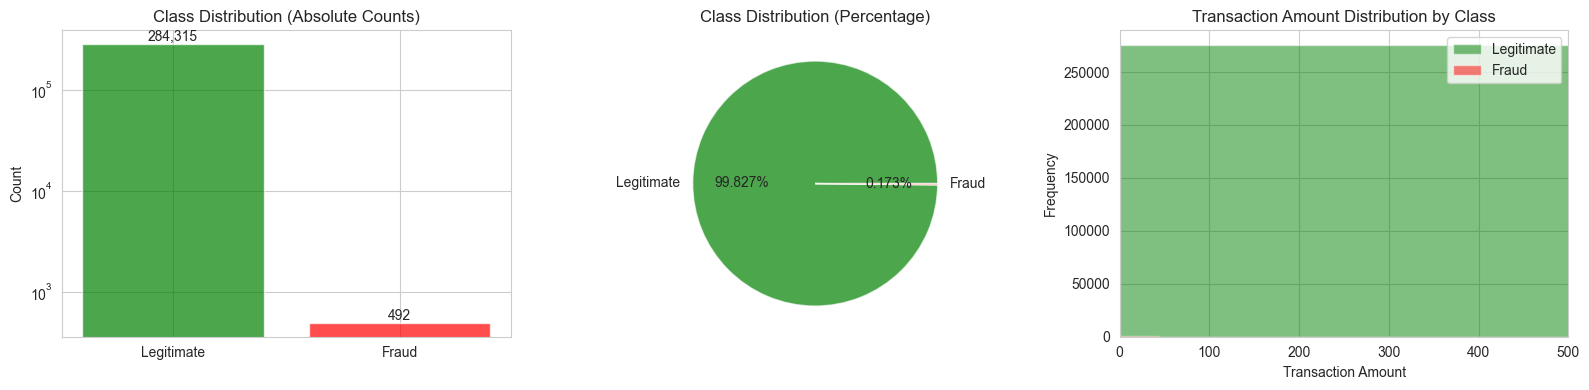


Transaction Amount Statistics:
Legitimate transactions:
count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

Fraudulent transactions:
count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64


In [8]:
# ============================================================================
# EXPLORATORY DATA ANALYSIS
# ============================================================================

print('\n' + '='*70)
print('CLASS DISTRIBUTION ANALYSIS')
print('='*70)

# Count fraud vs legitimate transactions
class_counts = df['Class'].value_counts()
fraud_count = class_counts[1]
legit_count = class_counts[0]
fraud_pct = (fraud_count / len(df)) * 100

print(f'\nLegitimate transactions: {legit_count:,} ({100-fraud_pct:.3f}%)')
print(f'Fraudulent transactions: {fraud_count:,} ({fraud_pct:.3f}%)')
print(f'Imbalance ratio: 1:{int(legit_count/fraud_count)} (fraud:legitimate)')

# Visualize class distribution
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Class distribution bar chart
axes[0].bar(['Legitimate', 'Fraud'], [legit_count, fraud_count], 
            color=['green', 'red'], alpha=0.7)
axes[0].set_ylabel('Count')
axes[0].set_title('Class Distribution (Absolute Counts)')
axes[0].set_yscale('log')  # Log scale to show both classes
for i, (label, count) in enumerate(zip(['Legitimate', 'Fraud'], [legit_count, fraud_count])):
    axes[0].text(i, count, f'{count:,}', ha='center', va='bottom')

# Class distribution pie chart
wedges, texts, autotexts = axes[1].pie([legit_count, fraud_count], labels=['Legitimate', 'Fraud'], 
            autopct='%1.3f%%', colors=['green', 'red'])
for w in wedges:
    w.set_alpha(0.7)
axes[1].set_title('Class Distribution (Percentage)')

# Amount distribution by class
df[df['Class'] == 0]['Amount'].hist(bins=50, alpha=0.5, label='Legitimate', 
                                      color='green', ax=axes[2])
df[df['Class'] == 1]['Amount'].hist(bins=50, alpha=0.5, label='Fraud', 
                                      color='red', ax=axes[2])
axes[2].set_xlabel('Transaction Amount')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Transaction Amount Distribution by Class')
axes[2].legend()
axes[2].set_xlim(0, 500)  # Focus on typical range

plt.tight_layout()
plt.show()

# Amount statistics by class
print('\nTransaction Amount Statistics:')
print('Legitimate transactions:')
print(df[df['Class'] == 0]['Amount'].describe())
print('\nFraudulent transactions:')
print(df[df['Class'] == 1]['Amount'].describe())

## Feature Preparation

Prepare features for machine learning:
1. **Separate features (X) and target (y)**
2. **Feature scaling**: Standardize Time and Amount features
   - V1-V28 are already PCA-transformed (scaled)
   - Time and Amount have different scales and need normalization
3. **Train/test split**: 80% training, 20% testing
   - Stratified split maintains class distribution in both sets

**Why scaling?** Logistic Regression and distance-based algorithms are sensitive to feature scales. XGBoost and Random Forest are more robust but still benefit from scaling.

In [9]:
# ============================================================================
# FEATURE PREPARATION
# ============================================================================

print('\n' + '='*70)
print('FEATURE PREPARATION')
print('='*70)

# Separate features and target
X = df.drop('Class', axis=1)
y = df['Class']

print(f'\nFeature matrix shape: {X.shape}')
print(f'Target vector shape: {y.shape}')
print(f'  Features: {list(X.columns)}')

# Feature scaling (StandardScaler: mean=0, std=1)
# Note: V1-V28 are already PCA-transformed, but Time and Amount need scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame for readability
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print(f'\nFeatures scaled using StandardScaler')
print('  Transformation: z = (x - mean) / std')
print('  Result: All features have mean≈0, std≈1')

# Train/test split (stratified to maintain class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE,
    stratify=y  # Maintain fraud ratio in both sets
)

print(f'\nTrain/test split:')
print(f'  Training set: {len(X_train):,} samples ({(1-TEST_SIZE)*100:.0f}%)')
print(f'  Test set: {len(X_test):,} samples ({TEST_SIZE*100:.0f}%)')

# Verify class distribution in splits
train_fraud_pct = (y_train.sum() / len(y_train)) * 100
test_fraud_pct = (y_test.sum() / len(y_test)) * 100
print(f'\n  Train fraud rate: {train_fraud_pct:.3f}%')
print(f'  Test fraud rate: {test_fraud_pct:.3f}%')
print(f'  Stratification successful (similar fraud rates)')


FEATURE PREPARATION

Feature matrix shape: (284807, 30)
Target vector shape: (284807,)
  Features: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

Features scaled using StandardScaler
  Transformation: z = (x - mean) / std
  Result: All features have mean≈0, std≈1

Features scaled using StandardScaler
  Transformation: z = (x - mean) / std
  Result: All features have mean≈0, std≈1

Train/test split:
  Training set: 227,845 samples (80%)
  Test set: 56,962 samples (20%)

  Train fraud rate: 0.173%
  Test fraud rate: 0.172%
  Stratification successful (similar fraud rates)

Train/test split:
  Training set: 227,845 samples (80%)
  Test set: 56,962 samples (20%)

  Train fraud rate: 0.173%
  Test fraud rate: 0.172%
  Stratification successful (similar fraud rates)


## Handle Class Imbalance with SMOTE

**Problem**: With only 0.172% fraud, models tend to predict everything as legitimate (99.83% accuracy but 0% fraud detection).

**Solution**: SMOTE (Synthetic Minority Over-sampling Technique)
- Generates synthetic fraud examples by interpolating between existing fraud cases
- Applied **only to training data** (not for test data)
- Balances classes to improve model's ability to learn fraud patterns

**SMOTE Algorithm**:
1. For each fraud transaction, find k nearest fraud neighbors
2. Randomly select one neighbor
3. Create synthetic sample along the line between them
4. Repeat until desired class balance achieved

**Critical**: We oversample to 50% (not 100%) to avoid overwhelming the model with synthetic data.

In [10]:
# ============================================================================
# HANDLE CLASS IMBALANCE WITH SMOTE
# ============================================================================

print('\n' + '='*70)
print('APPLYING SMOTE TO TRAINING DATA')
print('='*70)

# Class distribution before SMOTE
print('\nBefore SMOTE:')
train_class_counts = y_train.value_counts()
print(f'  Legitimate: {train_class_counts[0]:,}')
print(f'  Fraud: {train_class_counts[1]:,}')
print(f'  Imbalance ratio: 1:{int(train_class_counts[0]/train_class_counts[1])}')

# Apply SMOTE to training data only
smote = SMOTE(
    sampling_strategy=SMOTE_SAMPLING_STRATEGY,  # Oversample to 50% of majority
    k_neighbors=SMOTE_K_NEIGHBORS,              # Neighbors for synthesis
    random_state=RANDOM_STATE
)

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Class distribution after SMOTE
print('\nAfter SMOTE:')
resampled_class_counts = y_train_resampled.value_counts()
print(f'  Legitimate: {resampled_class_counts[0]:,}')
print(f'  Fraud: {resampled_class_counts[1]:,} (synthetic samples added)')
print(f'  Imbalance ratio: 1:{int(resampled_class_counts[0]/resampled_class_counts[1])}')

synthetic_added = resampled_class_counts[1] - train_class_counts[1]
print(f'\n  Synthetic fraud samples created: {synthetic_added:,}')
print(f'  Total training samples: {len(X_train_resampled):,}')

print('\n⚠ IMPORTANT: SMOTE applied to training data only!')
print('  Test set remains unchanged for unbiased evaluation')


APPLYING SMOTE TO TRAINING DATA

Before SMOTE:
  Legitimate: 227,451
  Fraud: 394
  Imbalance ratio: 1:577

After SMOTE:
  Legitimate: 227,451
  Fraud: 113,725 (synthetic samples added)
  Imbalance ratio: 1:2

  Synthetic fraud samples created: 113,331
  Total training samples: 341,176

⚠ IMPORTANT: SMOTE applied to training data only!
  Test set remains unchanged for unbiased evaluation

After SMOTE:
  Legitimate: 227,451
  Fraud: 113,725 (synthetic samples added)
  Imbalance ratio: 1:2

  Synthetic fraud samples created: 113,331
  Total training samples: 341,176

⚠ IMPORTANT: SMOTE applied to training data only!
  Test set remains unchanged for unbiased evaluation


## Train Models

Train three different classifiers on the SMOTE-balanced training data:

### 1. Logistic Regression (Baseline)
- Simple linear classifier
- Fast training and prediction
- Good baseline to compare against
- Interpretable coefficients

### 2. Random Forest (Ensemble)
- Ensemble of decision trees
- Handles non-linear patterns
- Robust to outliers
- Feature importance available

### 3. XGBoost (Gradient Boosting)
- State-of-the-art gradient boosting
- Often achieves best performance
- scale_pos_weight parameter helps with imbalance
- Efficient with large datasets

All models trained on SMOTE-balanced data, evaluated on original imbalanced test set.

In [11]:
# ============================================================================
# TRAIN MODELS
# ============================================================================

print('\n' + '='*70)
print('MODEL TRAINING')
print('='*70)

# Dictionary to store trained models
models = {}

# 1. Logistic Regression (Baseline)
# P(fraud) = 1 / (1 + e^-(w₁×V1 + w₂×V2 + ... + w₃₀×Amount + b))
print('\n[1/3] Training Logistic Regression...')
lr_model = LogisticRegression(
    max_iter=LR_MAX_ITER,
    solver=LR_SOLVER,
    random_state=RANDOM_STATE,
    n_jobs=-1  # Use all CPU cores
)
lr_model.fit(X_train_resampled, y_train_resampled)
models['Logistic Regression'] = lr_model
print('  ✓ Logistic Regression trained')

# 2. Random Forest
print('\n[2/3] Training Random Forest...')
rf_model = RandomForestClassifier(
    n_estimators=RF_N_ESTIMATORS,
    max_depth=RF_MAX_DEPTH,
    min_samples_split=RF_MIN_SAMPLES_SPLIT,
    min_samples_leaf=RF_MIN_SAMPLES_LEAF,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0
)
rf_model.fit(X_train_resampled, y_train_resampled)
models['Random Forest'] = rf_model
print('  ✓ Random Forest trained')

# 3. XGBoost
# Scale_pos_weight helps handle class imbalance by assigning higher weight to minority class
print('\n[3/3] Training XGBoost...')
xgb_model = xgb.XGBClassifier(
    learning_rate=XGB_LEARNING_RATE,
    max_depth=XGB_MAX_DEPTH,
    n_estimators=XGB_N_ESTIMATORS,
    scale_pos_weight=XGB_SCALE_POS_WEIGHT,  # Handle class imbalance
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbosity=0
)
xgb_model.fit(X_train_resampled, y_train_resampled)
models['XGBoost'] = xgb_model
print('  ✓ XGBoost trained')

print(f'\n✓ All {len(models)} models trained successfully!')


MODEL TRAINING

[1/3] Training Logistic Regression...
  ✓ Logistic Regression trained

[2/3] Training Random Forest...
  ✓ Logistic Regression trained

[2/3] Training Random Forest...
  ✓ Random Forest trained

[3/3] Training XGBoost...
  ✓ Random Forest trained

[3/3] Training XGBoost...
  ✓ XGBoost trained

✓ All 3 models trained successfully!
  ✓ XGBoost trained

✓ All 3 models trained successfully!


## Evaluate Models

Evaluate all models on the **original imbalanced test set** (not SMOTE-balanced).

### Key Metrics for Fraud Detection:

1. **Confusion Matrix**:
   - **True Positives (TP)**: Correctly identified fraud
   - **True Negatives (TN)**: Correctly identified legitimate
   - **False Positives (FP)**: Legitimate flagged as fraud (annoying for customers)
   - **False Negatives (FN)**: Fraud missed (costly for business)

2. **Precision**: Of predicted frauds, how many are real?
   - `Precision = TP / (TP + FP)`
   - High precision = fewer false alarms

3. **Recall (Sensitivity)**: Of actual frauds, how many did we catch?
   - `Recall = TP / (TP + FN)`
   - High recall = fewer frauds slip through

4. **F1-Score**: Harmonic mean of precision and recall
   - `F1 = 2 × (Precision × Recall) / (Precision + Recall)`
   - Balances precision and recall

5. **ROC-AUC**: Overall ranking quality (0.5 = random, 1.0 = perfect)

In [12]:
# ============================================================================
# EVALUATE MODELS
# ============================================================================

print('\n' + '='*70)
print('MODEL EVALUATION ON TEST SET')
print('='*70)

# Store results for comparison
results = []

for model_name, model in models.items():
    print(f'\n{model_name}:')
    print('-' * 70)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probability of fraud
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    # Store results
    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc,
        'TP': tp,
        'TN': tn,
        'FP': fp,
        'FN': fn
    })
    
    # Display metrics
    print(f'\nMetrics:')
    print(f'  Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)')
    print(f'  Precision: {precision:.4f} ({precision*100:.2f}%)')
    print(f'  Recall:    {recall:.4f} ({recall*100:.2f}%)')
    print(f'  F1-Score:  {f1:.4f}')
    print(f'  ROC-AUC:   {roc_auc:.4f}')
    
    print(f'\nConfusion Matrix:')
    print(f'  True Negatives (TN):  {tn:,} (correct legitimate predictions)')
    print(f'  False Positives (FP): {fp:,} (legitimate flagged as fraud)')
    print(f'  False Negatives (FN): {fn:,} (fraud missed - COSTLY!)')
    print(f'  True Positives (TP):  {tp:,} (correct fraud predictions)')
    
    print(f'\nInterpretation:')
    print(f'  ✓ Caught {tp} out of {tp+fn} frauds ({recall*100:.1f}%)')
    print(f'  ✓ {precision*100:.1f}% of fraud predictions were correct')
    print(f'  ⚠ Missed {fn} frauds (False Negatives)')
    print(f'  ⚠ {fp} false alarms (False Positives)')

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print('\n' + '='*70)
print('MODEL COMPARISON SUMMARY')
print('='*70)
print(results_df.to_string(index=False))


MODEL EVALUATION ON TEST SET

Logistic Regression:
----------------------------------------------------------------------

Metrics:
  Accuracy:  0.9868 (98.68%)
  Precision: 0.1062 (10.62%)
  Recall:    0.8980 (89.80%)
  F1-Score:  0.1899
  ROC-AUC:   0.9696

Confusion Matrix:
  True Negatives (TN):  56,123 (correct legitimate predictions)
  False Positives (FP): 741 (legitimate flagged as fraud)
  False Negatives (FN): 10 (fraud missed - COSTLY!)
  True Positives (TP):  88 (correct fraud predictions)

Interpretation:
  ✓ Caught 88 out of 98 frauds (89.8%)
  ✓ 10.6% of fraud predictions were correct
  ⚠ Missed 10 frauds (False Negatives)
  ⚠ 741 false alarms (False Positives)

Random Forest:
----------------------------------------------------------------------

Metrics:
  Accuracy:  0.9992 (99.92%)
  Precision: 0.7477 (74.77%)
  Recall:    0.8469 (84.69%)
  F1-Score:  0.7943
  ROC-AUC:   0.9782

Confusion Matrix:
  True Negatives (TN):  56,836 (correct legitimate predictions)
  False

## Visualize Results

Create comprehensive visualizations to compare model performance:
1. **Confusion matrices**: Visual comparison of TP, TN, FP, FN
2. **Metrics comparison**: Bar charts for Precision, Recall, F1, ROC-AUC
3. **ROC curves**: Trade-off between true positive rate and false positive rate

These visualizations help identify the best model for fraud detection.


Generating visualization...


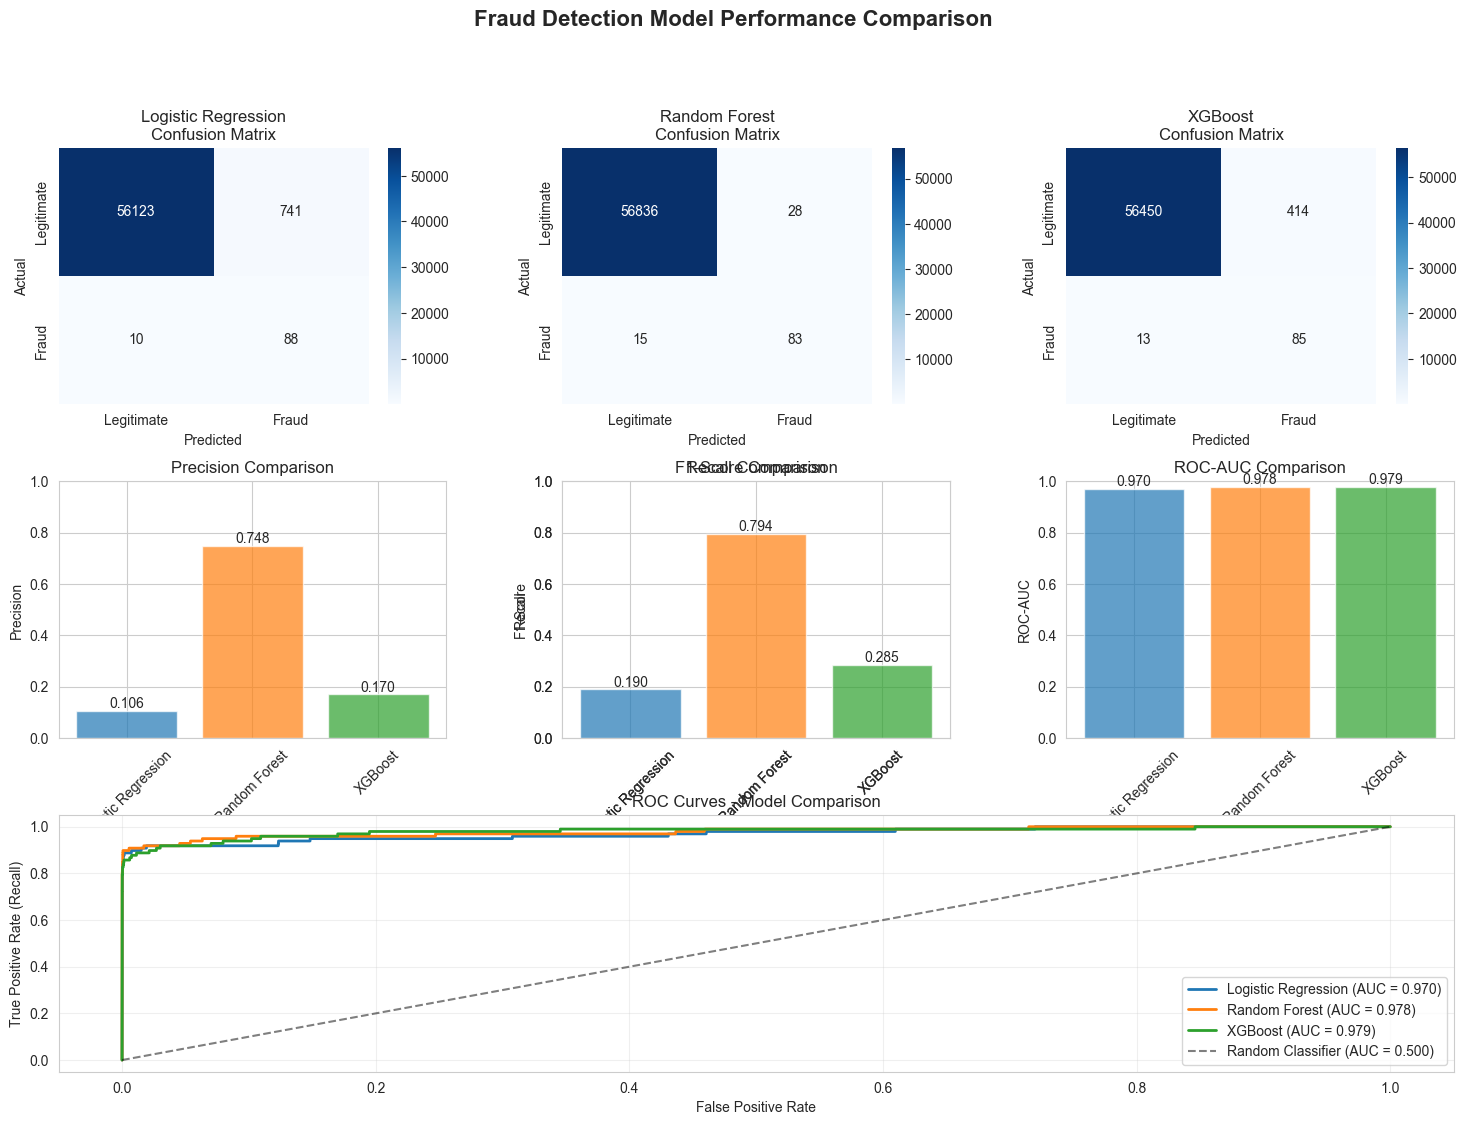

✓ Visualization complete!


In [13]:
# ============================================================================
# VISUALIZE RESULTS
# ============================================================================

print('\nGenerating visualization...')

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot confusion matrices (top row)
for idx, (model_name, model) in enumerate(models.items()):
    ax = fig.add_subplot(gs[0, idx])
    
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, 
                xticklabels=['Legitimate', 'Fraud'],
                yticklabels=['Legitimate', 'Fraud'])
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title(f'{model_name}\nConfusion Matrix')

# Plot metrics comparison (middle row)
metrics_to_plot = ['Precision', 'Recall', 'F1-Score', 'ROC-AUC']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for idx, metric in enumerate(metrics_to_plot):
    if idx < 2:
        ax = fig.add_subplot(gs[1, idx])
    else:
        ax = fig.add_subplot(gs[1, idx-2+1])
    
    values = results_df[metric].values
    bars = ax.bar(results_df['Model'], values, color=colors, alpha=0.7)
    
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} Comparison')
    ax.set_ylim(0, 1.0)
    ax.tick_params(axis='x', rotation=45)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{value:.3f}',
                ha='center', va='bottom')

# Plot ROC curves (bottom row, spanning all columns)
ax_roc = fig.add_subplot(gs[2, :])

for idx, (model_name, model) in enumerate(models.items()):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    
    ax_roc.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.3f})', 
                linewidth=2, color=colors[idx])

# Plot diagonal (random classifier)
ax_roc.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.500)', alpha=0.5)

ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate (Recall)')
ax_roc.set_title('ROC Curves - Model Comparison')
ax_roc.legend(loc='lower right')
ax_roc.grid(alpha=0.3)

plt.suptitle('Fraud Detection Model Performance Comparison', fontsize=16, fontweight='bold', y=0.995)
plt.show()

print('✓ Visualization complete!')

## Sample Predictions

Demonstrate the model on sample transactions to show input/output examples.

We'll select 3 examples:
1. **True Positive**: Actual fraud correctly identified
2. **True Negative**: Legitimate transaction correctly identified
3. **False Negative** (if any): Fraud that was missed

This provides concrete examples of how the model works in practice.

In [14]:
# ============================================================================
# SAMPLE PREDICTIONS
# ============================================================================

print('\n' + '='*70)
print('SAMPLE PREDICTIONS (Using Best Model)')
print('='*70)

# Use the best model (highest F1-score)
best_model_idx = results_df['F1-Score'].idxmax()
best_model_name = results_df.loc[best_model_idx, 'Model']
best_model = models[best_model_name]

print(f'\nBest model: {best_model_name}')
print(f'  F1-Score: {results_df.loc[best_model_idx, "F1-Score"]:.4f}')
print(f'  Recall: {results_df.loc[best_model_idx, "Recall"]:.4f}')

# Get predictions for test set
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Combine test data with predictions
test_results = X_test.copy()
test_results['Actual_Class'] = y_test.values
test_results['Predicted_Class'] = y_pred
test_results['Fraud_Probability'] = y_pred_proba

# Find examples
tp_examples = test_results[(test_results['Actual_Class'] == 1) & (test_results['Predicted_Class'] == 1)]
tn_examples = test_results[(test_results['Actual_Class'] == 0) & (test_results['Predicted_Class'] == 0)]
fn_examples = test_results[(test_results['Actual_Class'] == 1) & (test_results['Predicted_Class'] == 0)]

# Display 3 examples
print('\n' + '='*70)
print('EXAMPLE 1: True Positive (Fraud Correctly Detected)')
print('='*70)
if len(tp_examples) > 0:
    sample = tp_examples.iloc[0]
    print(f'\nInput Features:')
    print(f'  Time: {sample["Time"]:.2f}')
    print(f'  Amount: ${df.iloc[sample.name]["Amount"]:.2f}')
    print(f'  V1-V28: PCA-transformed features (anonymized)')
    print(f'\nOutput:')
    print(f'  Actual Class: FRAUD')
    print(f'  Predicted Class: FRAUD ✓')
    print(f'  Fraud Probability: {sample["Fraud_Probability"]:.1%}')
    print(f'\n  Result: CORRECT - Fraud successfully detected!')
else:
    print('  No true positive examples found')

print('\n' + '='*70)
print('EXAMPLE 2: True Negative (Legitimate Correctly Identified)')
print('='*70)
if len(tn_examples) > 0:
    sample = tn_examples.iloc[0]
    print(f'\nInput Features:')
    print(f'  Time: {sample["Time"]:.2f}')
    print(f'  Amount: ${df.iloc[sample.name]["Amount"]:.2f}')
    print(f'  V1-V28: PCA-transformed features (anonymized)')
    print(f'\nOutput:')
    print(f'  Actual Class: LEGITIMATE')
    print(f'  Predicted Class: LEGITIMATE ✓')
    print(f'  Fraud Probability: {sample["Fraud_Probability"]:.1%}')
    print(f'\n  Result: CORRECT - Legitimate transaction approved!')
else:
    print('  No true negative examples found')

print('\n' + '='*70)
print('EXAMPLE 3: False Negative (Fraud Missed)')
print('='*70)
if len(fn_examples) > 0:
    sample = fn_examples.iloc[0]
    print(f'\nInput Features:')
    print(f'  Time: {sample["Time"]:.2f}')
    print(f'  Amount: ${df.iloc[sample.name]["Amount"]:.2f}')
    print(f'  V1-V28: PCA-transformed features (anonymized)')
    print(f'\nOutput:')
    print(f'  Actual Class: FRAUD')
    print(f'  Predicted Class: LEGITIMATE ✗')
    print(f'  Fraud Probability: {sample["Fraud_Probability"]:.1%}')
    print(f'\n  Result: MISSED - This fraud was not detected (costly!)')
else:
    print('  ✓ No false negatives - all frauds detected!')

print('\n' + '='*70)


SAMPLE PREDICTIONS (Using Best Model)

Best model: Random Forest
  F1-Score: 0.7943
  Recall: 0.8469

EXAMPLE 1: True Positive (Fraud Correctly Detected)

Input Features:
  Time: -0.80
  Amount: $0.01
  V1-V28: PCA-transformed features (anonymized)

Output:
  Actual Class: FRAUD
  Predicted Class: FRAUD ✓
  Fraud Probability: 99.9%

  Result: CORRECT - Fraud successfully detected!

EXAMPLE 2: True Negative (Legitimate Correctly Identified)

Input Features:
  Time: 1.39
  Amount: $23.00
  V1-V28: PCA-transformed features (anonymized)

Output:
  Actual Class: LEGITIMATE
  Predicted Class: LEGITIMATE ✓
  Fraud Probability: 0.0%

  Result: CORRECT - Legitimate transaction approved!

EXAMPLE 3: False Negative (Fraud Missed)

Input Features:
  Time: -1.74
  Amount: $179.66
  V1-V28: PCA-transformed features (anonymized)

Output:
  Actual Class: FRAUD
  Predicted Class: LEGITIMATE ✗
  Fraud Probability: 46.7%

  Result: MISSED - This fraud was not detected (costly!)


EXAMPLE 1: True Positiv